# Inverse-Subset

This notebook constructs a subset of CIFAR-10 cat/dog data, on which it is better to train with inverted labels, rather than the true labels.

Steps executed:
1. Train a model on 15% of cat/dog training examples (-> 75% acc).
2. On the remaining 85% of examples, evaluate the model.
3. Take the 15% of those examples which is most confidently mis-predicted by the model.
4. Train a new model on this subset (-> 37% acc).

If the labels of this subset are inverted, it should be clear due to symmetry that this will yield 100 - 37 = 63% accuracy.

This version uses FFCV so that training isn't painfully slow.

In [2]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader

from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

from ffcv.writer import DatasetWriter
from ffcv.fields import IntField, RGBImageField

In [3]:
def submask(mask, m):
    xx = torch.rand(len(mask))
    q = xx[mask].quantile(m/mask.sum())
    return mask & (xx < q)

class Ensemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
    def forward(self, x):
        outs = [m(x) for m in self.models]
        return torch.stack(outs).mean(0)

In [5]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

class TransformWrapperDataset:
    def __init__(self, dset, transform):
        self.dset = dset
        self.transform = transform
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, i):
        x, y = self.dset[i]
        return self.transform(x), y

class CifarSubset:
    def __init__(self, ii, train=True, aug=None, invert_ii=None):
        self.ii = ii
        self.dset = CIFAR10('/tmp', train=train, download=True)
        if isinstance(invert_ii, torch.Tensor):
            invert_ii = invert_ii.tolist()
        self.invert_ii = set(invert_ii) if invert_ii else set()
        
    def __len__(self):
        return len(self.ii)
    
    def __getitem__(self, i):
        x, y = self.dset[self.ii[i]]
        if self.ii[i] in self.invert_ii:
            if y == 3:
                y = 5
            elif y == 5:
                y = 3
        return x, y
    
    def loader(self, bs=500, aug=False, shuffle=None):
        normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
        if shuffle is None:
            shuffle = aug
        if aug:
            transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(32, padding=2),
                T.ToTensor(),
                normalize,
            ])
        else:
            transform = T.Compose([
                T.ToTensor(),
                normalize,
            ])
        loader = DataLoader(TransformWrapperDataset(self, transform),
                            batch_size=bs, shuffle=shuffle, num_workers=8)
        return loader
    
    def ffcv(self, name, bs=500, aug=False, shuffle=None, invert=False):
        p = f'/tmp/cifar_{name}.beton'
        if os.path.exists(p):
            os.remove(p)
        if not os.path.exists(p):
            print('Writing new ffcv dset...')
            writer = DatasetWriter(p, {
                'image': RGBImageField(),
                'label': IntField()
            })  
            writer.from_indexed_dataset(self)

        device = 'cuda:0'
        label_pipeline = [IntDecoder(), ToTensor(), ToDevice(device), Squeeze()]
        image_pipeline = [SimpleRGBImageDecoder()]
        if aug:
            image_pipeline.extend([
                RandomHorizontalFlip(),
                RandomTranslate(padding=2),
#                 Cutout(8, tuple(map(int, CIFAR_MEAN))),
            ])  
        image_pipeline.extend([
            ToTensor(),
            ToDevice(device, non_blocking=True),
            ToTorchImage(),
            Convert(torch.float16),
            T.Normalize(CIFAR_MEAN, CIFAR_STD),
        ])
        if shuffle is None:
            shuffle = aug
        order_opt = OrderOption.RANDOM if shuffle else OrderOption.SEQUENTIAL
        loader = Loader(p,
                        batch_size=bs,
                        num_workers=8,
                        order=order_opt,
                        drop_last=aug,
                        pipelines={'image': image_pipeline,
                                   'label': label_pipeline})
        if invert:
            return InvertLoader(loader)
        else:
            return loader

In [6]:
def create_model(w=1.0):

    class Mul(nn.Module):
        def __init__(self, weight):
            super().__init__()
            self.weight = weight
        def forward(self, x): 
            return x * self.weight

    class Flatten(nn.Module):
        def forward(self, x): 
            return x.view(x.size(0), -1) 

    class Residual(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, x): 
            return x + self.module(x)

    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1):
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=kernel_size, stride=stride, padding=padding,
                          bias=False),
                nn.BatchNorm2d(channels_out),
                nn.ReLU(inplace=True)
        )   

    NUM_CLASSES = 10
    w0 = int(w*64)
    w1 = int(w*128)
    w2 = int(w*256)
    model = nn.Sequential(
        conv_bn(3, w0, kernel_size=3, stride=1, padding=1),
        conv_bn(w0, w1, kernel_size=5, stride=2, padding=2),
        Residual(nn.Sequential(conv_bn(w1, w1), conv_bn(w1, w1))),
        conv_bn(w1, w2, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2),
        Residual(nn.Sequential(conv_bn(w2, w2), conv_bn(w2, w2))),
        conv_bn(w2, w1, kernel_size=3, stride=1, padding=0),
        nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        nn.Linear(w1, NUM_CLASSES, bias=False),
        Mul(0.2)
    )   
    model = model.to(memory_format=torch.channels_last)
    return model

In [7]:
def evaluate(model):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad(), autocast():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            count += len(labels)
    return correct / count

In [8]:
loss_fn = CrossEntropyLoss()

def train(loader, epochs=150):

    # lr = 0.5
    lr = 1.0
    n_iters = epochs * len(train_loader)
    lr_schedule = np.interp(np.arange(1+n_iters), [0, n_iters], [1, 0])
    
    model = create_model(w=1.0).cuda()
    scaler = GradScaler()

    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    losses = []
    accs = []
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in loader:
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            losses.append(loss.item())
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        if epoch % 5 == 0:
            acc = evaluate(model)
            accs.append(acc)
    plt.figure(figsize=(3, 2))
    plt.title('loss')
    plt.plot(losses)
    plt.ylim(0, 2.5)
    plt.show()
    plt.figure(figsize=(3, 2))
    plt.title('acc')
    plt.plot(accs)
    plt.show()
    return model

In [9]:
## cat/dog test-set
tgt_test = torch.tensor(CIFAR10('/tmp', train=False, download=True).targets)
mask = (tgt_test == 3) | (tgt_test == 5)
test_loader = CifarSubset(torch.arange(10000)[mask], train=False).ffcv('catdog_test', aug=False)

Files already downloaded and verified
Files already downloaded and verified
Writing new ffcv dset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 19957.24it/s]


Files already downloaded and verified
Files already downloaded and verified
Writing new ffcv dset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.15it/s]


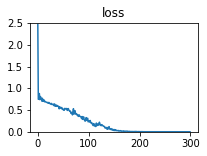

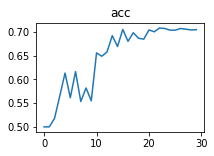

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.29it/s]


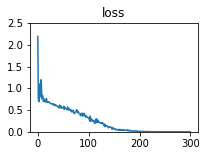

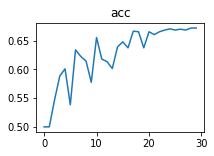

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.27it/s]


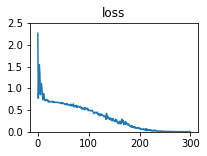

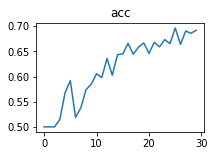

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:14<00:00, 10.14it/s]


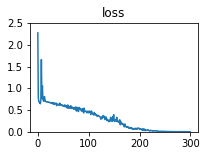

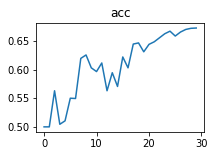

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:15<00:00,  9.51it/s]


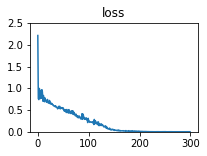

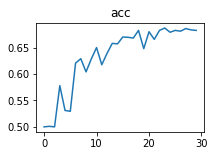

acc: 0.7105


In [10]:
## cat/dog train-set
tgt_train = torch.tensor(CIFAR10('/tmp', train=True, download=True).targets)
mask = (tgt_train == 3) | (tgt_train == 5)
ii0 = torch.arange(50000)[mask]
train_loader = CifarSubset(ii0[:1000], train=True).ffcv('catdog_train_10p', aug=True, shuffle=True) # first 10%

models0 = [train(train_loader) for _ in range(5)]
model0 = Ensemble(models0)
print('acc:', evaluate(model0))

In [11]:
train_loader = CifarSubset(ii0[1000:], train=True).ffcv('catdog_train_90p', aug=True, shuffle=False)
outputs_l = []
labels_l = []
model = model0
model.eval()
k = 20
for _ in tqdm(range(k)):
    with torch.no_grad(), autocast():
        for inputs, labels in train_loader:
            outputs = model(inputs.cuda())
            outputs_l.append(outputs.cpu())
            labels_l.append(labels.clone().cpu())
outputs = torch.cat(outputs_l).reshape(k, -1, outputs_l[0].size(-1)).mean(0)
deltas = outputs[:, 5] - outputs[:, 3]
labels = torch.cat(labels_l).reshape(k, -1)[0]
y_true = (labels == 5)
conf_correct = deltas * (2 * y_true.float() - 1)

Files already downloaded and verified
Writing new ffcv dset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20it/s]


In [12]:
mask_cat = (tgt_train[ii0] == 3)[1000:]
n = 1500
q1 = conf_correct[~mask_cat].quantile(n/9000)
mask1 = (conf_correct < q1)
q2 = conf_correct[mask_cat].quantile(n/9000)
mask2 = (conf_correct < q2)
mask = (mask1 & ~mask_cat) | (mask2 & mask_cat)
print(q1, q2)

ii1 = ii0[1000:][mask]
print('num:', len(ii1))
# print(pd.Series(tgt_train[ii1]).value_counts() / len(ii1))
train_loader = CifarSubset(ii1, train=True).ffcv('catdog_train_hard_15p', aug=True)

tensor(-2.5781) tensor(-1.9766)
num: 1500
Files already downloaded and verified
Writing new ffcv dset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 14950.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.17it/s]


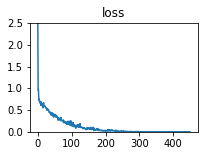

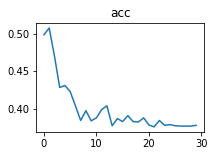

acc: 0.377


In [13]:
model2 = train(train_loader)
print('acc:', evaluate(model2))

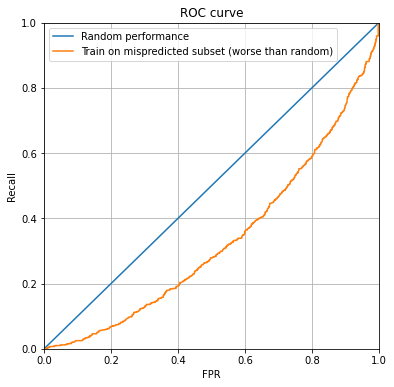

In [14]:
## collect logit deltas to visualize ROC curve
outputs_l = []
labels_l = []
model2.eval()
with torch.no_grad(), autocast():
    for inputs, labels in test_loader:
        outputs_l.append(model2(inputs.cuda()).cpu())
        labels_l.append(labels.clone().cpu())
outputs = torch.cat(outputs_l)
labels = torch.cat(labels_l)
deltas = (outputs[:, 5] - outputs[:, 3]).cpu()

y_score = deltas
y_true = (labels == 5)

plt.figure(figsize=(6, 6))

plt.plot([0, 1], [0, 1], label='Random performance')
# plt.scatter([0.5, 0.5], [0.5, 0.5])

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_score)
# y_pred = (y_score > 0).float()
# tpr0 = (y_pred * y_true.float()).sum() / y_true.float().sum()
# fpr0 = 1 - ((1 - y_pred) * (1 - y_true.float())).sum() / (1 - y_true.float()).sum()
plt.plot(fpr, tpr, label='Train on mispredicted subset (worse than random)')
# plt.scatter([fpr0], [tpr0])

plt.xlabel('FPR')
plt.ylabel('Recall')
plt.title('ROC curve')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

## interaction

Def B as invert-set (hardest 1500  out of last 9k, when training on first 1k)
* B -> 37.5%
* ~B -> 62.5%

Def A as last 9k minus B (-> 7500 examples)
* A -> 85.5%
* A+B -> 90.6%
* A+~B -> 75.9%

Def A as last 4k minus B (-> 3328 examples)
* A -> 81.6%
* A+B -> 86.3%
* A+~B -> 

Def A as last 2k
* A+B isn't better than A, while A+~B is still worse
Def A as last 1k
* A+B is worse than A, and A+~B is better

In [19]:
ii_a = ii0[:].tolist()
# ii_a = ii0[:5000].tolist()
# ii_a = ii0[-3000:].tolist()
ii_b = ii1.tolist()
ii_a = list(set(ii_a) - set(ii_b))
ii_c = ii_a+ii_b
print(len(ii_a), len(ii_b), len(ii_c))

8500 1500 10000


Files already downloaded and verified
Writing new ffcv dset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


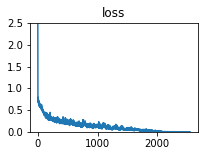

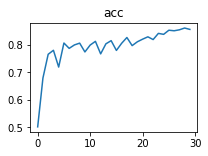

acc: 0.8585


In [20]:
train_loader = CifarSubset(ii_a, train=True).ffcv('catdog_train_v11', aug=True)
model3 = train(train_loader)
print('acc:', evaluate(model3))

Files already downloaded and verified
Writing new ffcv dset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.50it/s]


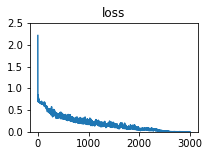

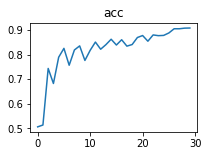

acc: 0.9075


In [21]:
train_loader = CifarSubset(ii_c, train=True).ffcv('catdog_train_v13', aug=True)
model3 = train(train_loader)
print('acc:', evaluate(model3))

Files already downloaded and verified
Writing new ffcv dset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.53it/s]


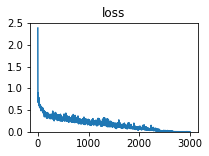

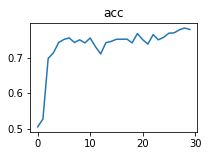

acc: 0.776


In [22]:
train_loader = CifarSubset(ii_c, train=True, invert_ii=ii_b).ffcv('catdog_train_v15', aug=True)
model3 = train(train_loader)
print('acc:', evaluate(model3))